In [1]:
!pip install opencv-contrib-python
!pip install imutils

In [2]:
#import pytesseract
from imutils import paths
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.segmentation import clear_border
import numpy as np
import skimage 
from PIL import Image
#from imutils.perspective import four_point_transform
%matplotlib inline

In [3]:
# module level variables ##########################################################################
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9

###################################################################################################
def preprocess(imgOriginal):
    imgSaturation, imgGrayscale = extractValue(imgOriginal)

    imgMaxContrastGrayscale = maximizeContrast(imgGrayscale)

    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)

    imgThreshValue = cv2.threshold(imgBlurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    imgThreshSaturation = cv2.threshold(imgSaturation, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # plt.imshow(imgBlurred,cmap='gray')
    # plt.show()
    # plt.imshow(imgThreshValue,cmap='gray')
    # plt.show()

    # plt.imshow(imgSaturation,cmap='gray')
    # plt.show()
    # plt.imshow(imgThreshSaturation,cmap='gray')
    # plt.show()

    #imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)
    
    return imgGrayscale, (imgThreshValue & (255 - imgThreshSaturation))
# end function

###################################################################################################
def extractValue(imgOriginal):
    height, width, numChannels = imgOriginal.shape

    imgHSV = np.zeros((height, width, 3), np.uint8)

    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)

    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)

    return imgSaturation, imgValue
# end function

###################################################################################################
def maximizeContrast(imgGrayscale):

    height, width = imgGrayscale.shape

    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat
# end function

In [4]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [5]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

In [6]:
def contourApprox(imgOriginal, cnts):
	# initialize a contour that corresponds to the receipt outline
	receiptCnt = None
	# loop over the contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.05 * peri, True)

		#drawnContour = imgOriginal.copy()
		#cv2.drawContours(drawnContour, [approx], -1, (0, 255, 0), 2)
		#plt.imshow(drawnContour)
		#plt.show()

		# if our approximated contour has four points, then we can
		# assume we have found the outline of the receipt
		if len(approx) == 4:
			receiptCnt = approx
			break
		else:
			receiptCnt = cv2.convexHull(approx)
			if len(receiptCnt) == 4:
				break		
	# if the receipt contour is empty then our script could not find the
	# outline and we should be notified
	return receiptCnt

In [41]:
def showApprox(imgOriginal, thresh, receiptCnt):
    cv2.drawContours(imgOriginal, [receiptCnt], -1, (0, 255, 0), 2)
    #print(output[1])
    plt.imshow(imgOriginal)
    plt.show()
    rect_coor = np.array(receiptCnt.reshape(4,2))
    img = four_point_transform(imgOriginal, rect_coor)
    #print(img.shape)
    #img_new = add_margin(img, 5, 10, 0, 10)
    _, final_img = preprocess(img)
    plt.imshow(final_img, cmap="gray")
    plt.show()
    return (final_img,img)
    #print(f"boundaries = {receiptCnt.reshape(4, 2)}")


In [42]:
def add_margin(pil_img, top, right, bottom, left, color=(255,255,255)):
    height,width,_ = pil_img.shape
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new('RGB', (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [56]:
def CutLetters(img,rgb_img):
    height, width = img.shape
    windowWidthR = int(0.18 * width)
    windowWidthL = int(0.15 * width)
    windowWidth = windowWidthR
    windowHeight = img.shape[0]
    marginWidth = int(windowWidth * 0.05)
    stepSize = 5
    GroupSize = 8
    lowerBlackLimit = 0.12
    upperBlackLimit = 0.9

    Letters = []
    Letters_imgs = []
    for i in range(0, width - (windowWidth), stepSize * GroupSize):

        Group = []
        for j in range(i, min(i + stepSize * GroupSize, width - (windowWidth)), stepSize):
            #plt.imshow(img[:, j:j+windowWidth],cmap='gray')
            #plt.show()
            if j <= width/2:
                windowWidth = windowWidthL
            else:
                windowWidth = windowWidthR

            blackCountMarginL = marginWidth * height  - np.count_nonzero(img[:, j : j+marginWidth])
            blackCountMarginR = marginWidth * height  - np.count_nonzero(img[:, j+windowWidth-marginWidth : j+windowWidth])
            blackCountInner = (windowWidth - 2 * marginWidth) * height - np.count_nonzero(img[:, j+marginWidth : j+windowWidth-marginWidth])
            
            #print(blackCountMarginL, marginWidth * height)
            #print(blackCountMarginR, marginWidth * height)
            #print(blackCountInner, (windowWidth - 2 * marginWidth) * height)
            #and blackCountMarginR < 0.2 * marginWidth * height \

            if blackCountMarginL < 0.17 * marginWidth * height and blackCountInner > lowerBlackLimit * (windowWidth - 2 * marginWidth) * height \
                and blackCountInner < upperBlackLimit * (windowWidth - 2 * marginWidth) * height:
                Group.append((blackCountInner, j))
        if len(Group) > 0:
            max_G = max(Group)[1]
            Letters.append(max_G)
            # rect_coord = [rgb_img[0][0],rgb_img[0][-1],max(Group)[1],max(Group)[1]+windowWidth]
            # rect_coord = np.array(rect_coord,dtype='int32')
            rgb2_img = rgb_img[:, max_G:max_G+windowWidth]
            Letters_imgs.append(rgb2_img)
            plt.imshow(rgb2_img)
            #plt.imshow(img[:, max(Group)[1]:max(Group)[1]+windowWidth],cmap='gray')
            plt.show()

    return Letters_imgs






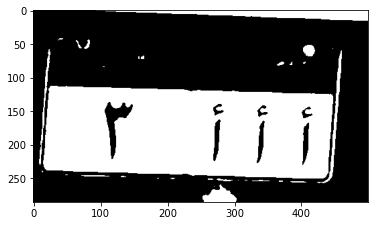

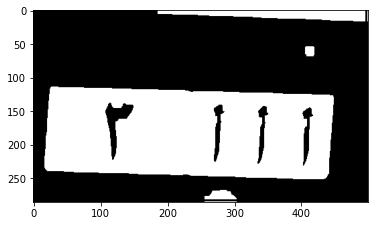

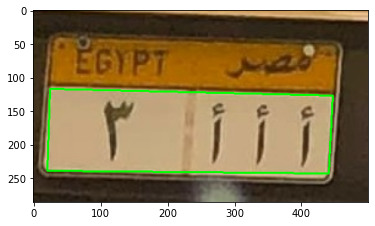

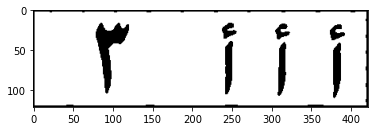

index = 211


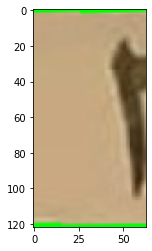

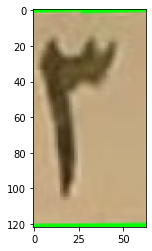

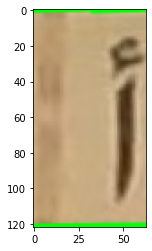

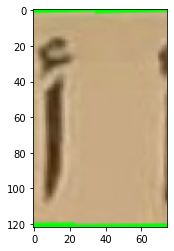

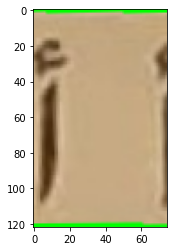

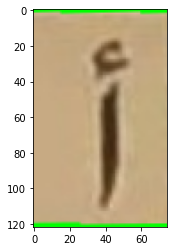

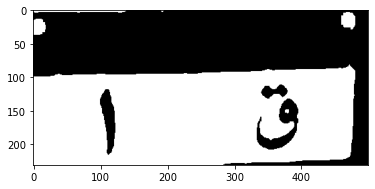

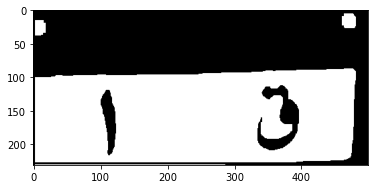

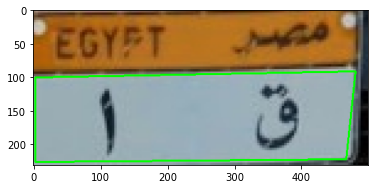

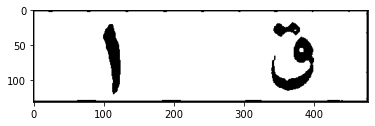

index = 239


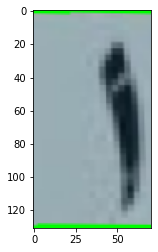

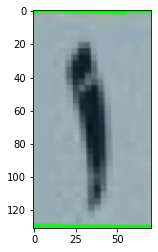

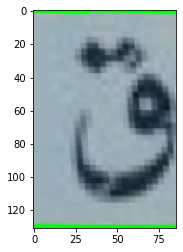

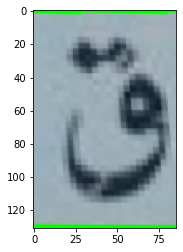

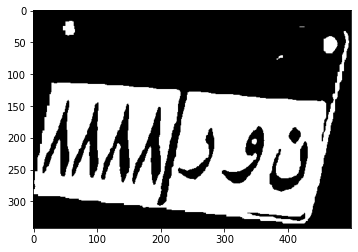

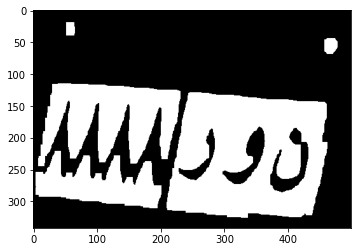

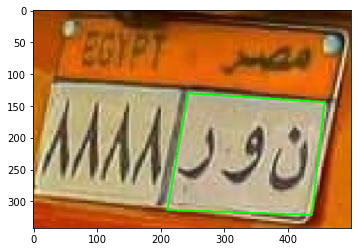

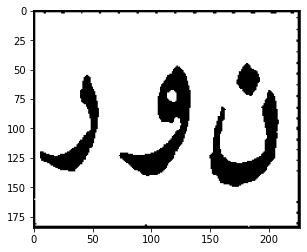

index = 113


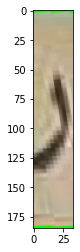

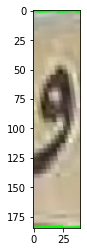

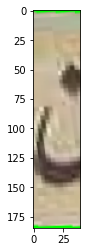

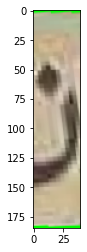

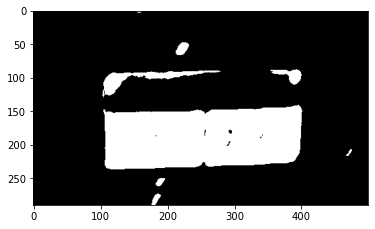

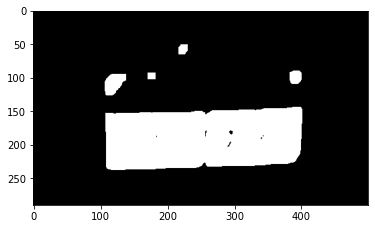

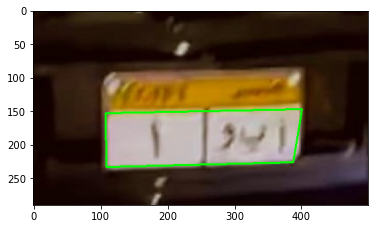

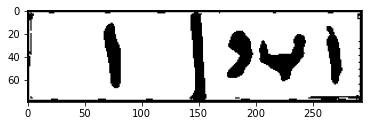

index = 146


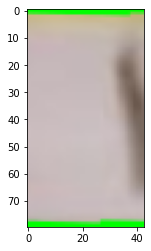

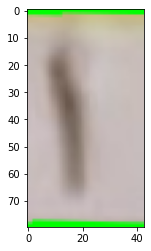

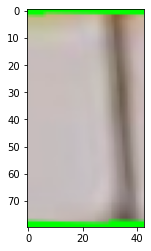

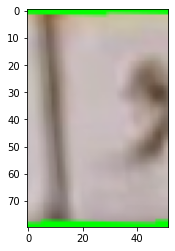

KeyboardInterrupt: 

In [57]:
for i in range(30):
    imgOriginal = cv2.imread(f"./test_images/{str(i).zfill(5)}.jpg")
    #imgOriginal = cv2.imread("./train_images/02937.jpg")
    #img = imgOriginal.copy()
    imgOriginal = imutils.resize(imgOriginal, width=500)
    #ratio = img.shape[1] / float(imgOriginal.shape[1])
    #plt.imshow(imgOriginal)
    #plt.show()
    gray,thresh = preprocess(imgOriginal)
    # plt.imshow(gray,cmap='gray')
    # plt.show()
    plt.imshow(thresh,cmap='gray')
    plt.show()

    #ClosedThresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3)))
    OpenedThresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)))

    minValue = np.min(OpenedThresh)

    OpenedThresh[imgOriginal.shape[0]-4:imgOriginal.shape[0]-1, :] = minValue
    OpenedThresh[:, imgOriginal.shape[1]-4:imgOriginal.shape[1]-1] = minValue
    OpenedThresh[:, 0:3] = minValue


    plt.imshow(OpenedThresh,cmap='gray')
    plt.show()



    #plt.imshow(ClosedThresh,cmap='gray')
    #plt.show()
    

    cnts = cv2.findContours(OpenedThresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # for c in cnts:
        # #print(c[0])
        # plt.scatter(c[:, 0, 0], -c[:, 0, 1])
        # plt.show()
    # np.array(cnts,dtype=np.int32).shape
    #print(cnts[-1])
    receiptCnt = contourApprox(imgOriginal, cnts)
    if receiptCnt is None:
        
        receiptCnt = np.array([[[0,  0]], [[0, imgOriginal.shape[0]]],
         [[imgOriginal.shape[1], imgOriginal.shape[0]]], [[imgOriginal.shape[1], 0]]])
    #print(receiptCnt)
    final_img ,rgb_img= showApprox(imgOriginal, thresh, receiptCnt)
    
    #resized_img = imutils.resize(final_img[:,:int(final_img.shape[1]/2)], width=int(1.5 * final_img.shape[1]/2))
    #new_img = np.concatenate((resized_img,final_img[:,int(final_img.shape[1]/2):]),axis=1)
    print(f"index = {int(final_img.shape[1]/2)}")
    
    #print(resized_img.shape[1])
    # new_im = Image.new('RGB', (resized_img.shape[0]+final_img[:,int(final_img.shape[1]/2):].shape[1],
    # max(resized_img.shape[0],final_img.shape[0])), (250,250,250))
  
    # new_im.paste(resized_img, (0,0))
    # new_im.paste(final_img[:,int(final_img.shape[1]/2):], (resized_img.shape[1],0))
    # plt.imshow(new_im)
    # plt.show()
    #CutLetters(rgb_img)
    letters_cropped = CutLetters(final_img,rgb_img)
    #print(final_img.shape[1])
    #CharacterContours(final_img)

# plt.plot(cnts[0])
# plt.show()

#cnts = skimage.measure.find_contours(thresh)
#cnts = sorted(cnts, reverse=True)
#cnts

# for c in cnts:
#     # compute the bounding box of the contour and then use
#     # the bounding box to derive the aspect ratio
#     (x, y, w, h) = cv2.boundingRect(c)
#     ar = w / float(h)
#     if ar >= 2 and ar <= 10:
#         lpCnt = c
#         letter = gray[y:y + h, x:x + w]
#         roi = cv2.threshold(letter, 0, 255,
#                 cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#             # check to see if we should clear any foreground
#             # pixels touching the border of the image
#             # (which typically, not but always, indicates noise)
#         # display any debugging information and then break
#         # from the loop early since we have found the license
#         # plate region
#         # plt.plot(letter,cmap='gray')
#         # plt.show()
#         plt.plot(roi,cmap='gray')
#         plt.show()
#         print("****************")
# print(roi)   

In [ ]:
## Trying to get letters from cropped image, not working yet
def CharacterContours(thresh_img):
    cnts2 = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts2 = imutils.grab_contours(cnts2)
    cnts2 = sorted(cnts2, key=cv2.contourArea, reverse=True)
    #cv2.drawContours(thresh_img, cnts, -1, (0, 255, 0), 2)
    plt.imshow(thresh_img, cmap="gray")
    plt.show()

    letters = []
    letters_adj = []
    for c in cnts2:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.1 * peri, True)
        letters.append(approx)
    #print(letters)
    #print(len(cnts))
    #print(len(letters))
    # for i in range(len(letters)):
    #     # print(i)
    #     arr = np.array(letters[i],dtype='int32')
    #     # arr.reshape(4,2)
    #     arr = arr.reshape(len(arr[:]),2)
    #     letters_adj.append(arr)
    #print(letters_adj[1].reshape(len(letters_adj[1][:]),2))
    # print(letters_adj[2])
    # output2 = final_img.copy()
    # cv2.drawContours(output2, [letters_adj[6]], -1, (0, 255, 0), 2)
    # plt.imshow(output2)
    # plt.show()
    # letters_img = four_point_transform(final_img, letters_adj[1])
    # plt.imshow(letters_img)
    # plt.show()

